# Testing LPP MEG data's validity


## Purpose
The purpose of this notebook is to investigate the correct epoching and trigger time matching for the MEG recordings of the LPP paradigm.

## Methodology
- For each subject, get the 9 epochs corresponding to the first trigger (start of audio).
- Average the MEG channels to see if there's an evoked response to the first audio stimuli

## WIP - improvements
Notable TODOs:
- todo 1;
- todo 2;
- todo 3.

## Results
Describe and comment the most important results.

## Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

## Library import
We import all the required Python libraries

In [22]:
# Imports

import mne
import mne_bids
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, scale
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib
from joblib import Parallel, delayed
matplotlib.use("Agg")
mne.set_log_level(False)
import time
import os

%matplotlib inline

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [77]:
bids = "/home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all"
bids_raw = "/home/is153802/workspace_LPP/data/MEG/LPP/LPP_bids"


# Data import
We retrieve all the required data for the analysis.

In [5]:
subjects = pd.read_csv(bids + "/participants.tsv", sep="\t")
subjects = subjects.participant_id.apply(lambda x: x.split("-")[1]).values
subjects = np.delete(subjects,subjects.shape[0]-1)
print(subjects)

['180131' '180517' '181017' '190506' '190513' '190611' '190621' '190715'
 '190717' '220628' '220707']


Rename the fif files that have been preprocessed to the BIDS standart (*_raw.fif to *_meg.fif)

In [29]:
# Done already for the current batch of filtered data by the MNE BIDS Pipeline
"""
for subject in subjects:
    subj_path = os.path.join(bids,'sub-'+subject,'ses-01/meg')
    for filename in os.listdir(subj_path):
        infilename = os.path.join(subj_path,filename)
        if not os.path.isfile(infilename): continue
        oldbase = os.path.splitext(filename)
        newname = infilename.replace('raw.fif', 'meg.fif')
        output = os.rename(infilename, newname)
        
"""

Add the needed files (events, headposition & co) to the newly generated post-processing folders (done manually; faster than doing a regex)

# Data processing


## Trying to use the first trigger to see the evoked response

In [79]:
bids_path = mne_bids.BIDSPath(
                subject='220707',
                session='01',
                task='rest',
                datatype="meg",
                root=bids_raw,
                run = '01'
            )

print(bids_path)
raw = mne_bids.read_raw_bids(bids_path)

raw = raw.pick_types(
    meg=True, misc=False, eeg=False, eog=False, ecg=False
)

raw.load_data().filter(0.5, 30.0, n_jobs=1)

/home/is153802/workspace_LPP/data/MEG/LPP/LPP_bids/sub-220707/ses-01/meg/sub-220707_ses-01_task-rest_run-01_meg.fif


/tmp/ipykernel_352459/1652585085.py:11: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/1652585085.py:11: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


<Raw | sub-220707_ses-01_task-rest_run-01_meg.fif, 306 x 633000 (633.0 s), ~1.45 GB, data loaded>

In [86]:
raw

<Info | 25 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dev_head_t: MEG device -> head transform
 dig: 141 items (3 Cardinal, 4 HPI, 134 Extra)
 events: 1 item (list)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 30.0 Hz
 maxshield: True
 meas_date: 2022-07-07 11:58:52 UTC
 meas_id: 4 items (dict)
 nchan: 306
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: mne_anonymize
 projs: grad_ssp_upright.fif : PCA-v1: off, grad_ssp_upright.fif : ...
 sfreq: 1000.0 Hz
 subject_info: 4 items (dict)
>

In [84]:
raw_ = raw.copy().pick_types(meg=False, stim=True)

ValueError: No channels match the selection.

In [71]:
bids_path = mne_bids.BIDSPath(
                subject='220707',
                session='01',
                task='rest',
                datatype="meg",
                root=bids,
                run = '01',
                processing = "sss"
            )

print(bids_path)
raw = mne_bids.read_raw_bids(bids_path)

raw = raw.pick_types(
    meg=True, misc=False, eeg=False, eog=False, ecg=False
)

raw.load_data().filter(0.5, 30.0, n_jobs=1)

/home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all/sub-220707/ses-01/meg/sub-220707_ses-01_task-rest_run-01_proc-sss_meg.fif


/tmp/ipykernel_352459/926989393.py:12: RuntimeWarning: The number of channels in the channels.tsv sidecar file (346) does not match the number of channels in the raw data file (309). Will not try to set channel names.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/926989393.py:12: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC201, MISC202, MISC203, MISC204, MISC205, MISC206, MISC301, MISC302, MISC303, MISC304, MISC305, MISC306, STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301
  raw = mne_bids.read_raw_bids(bids_path)


<Raw | sub-220707_ses-01_task-rest_run-01_proc-sss_meg.fif, 306 x 633000 (633.0 s), ~1.45 GB, data loaded>

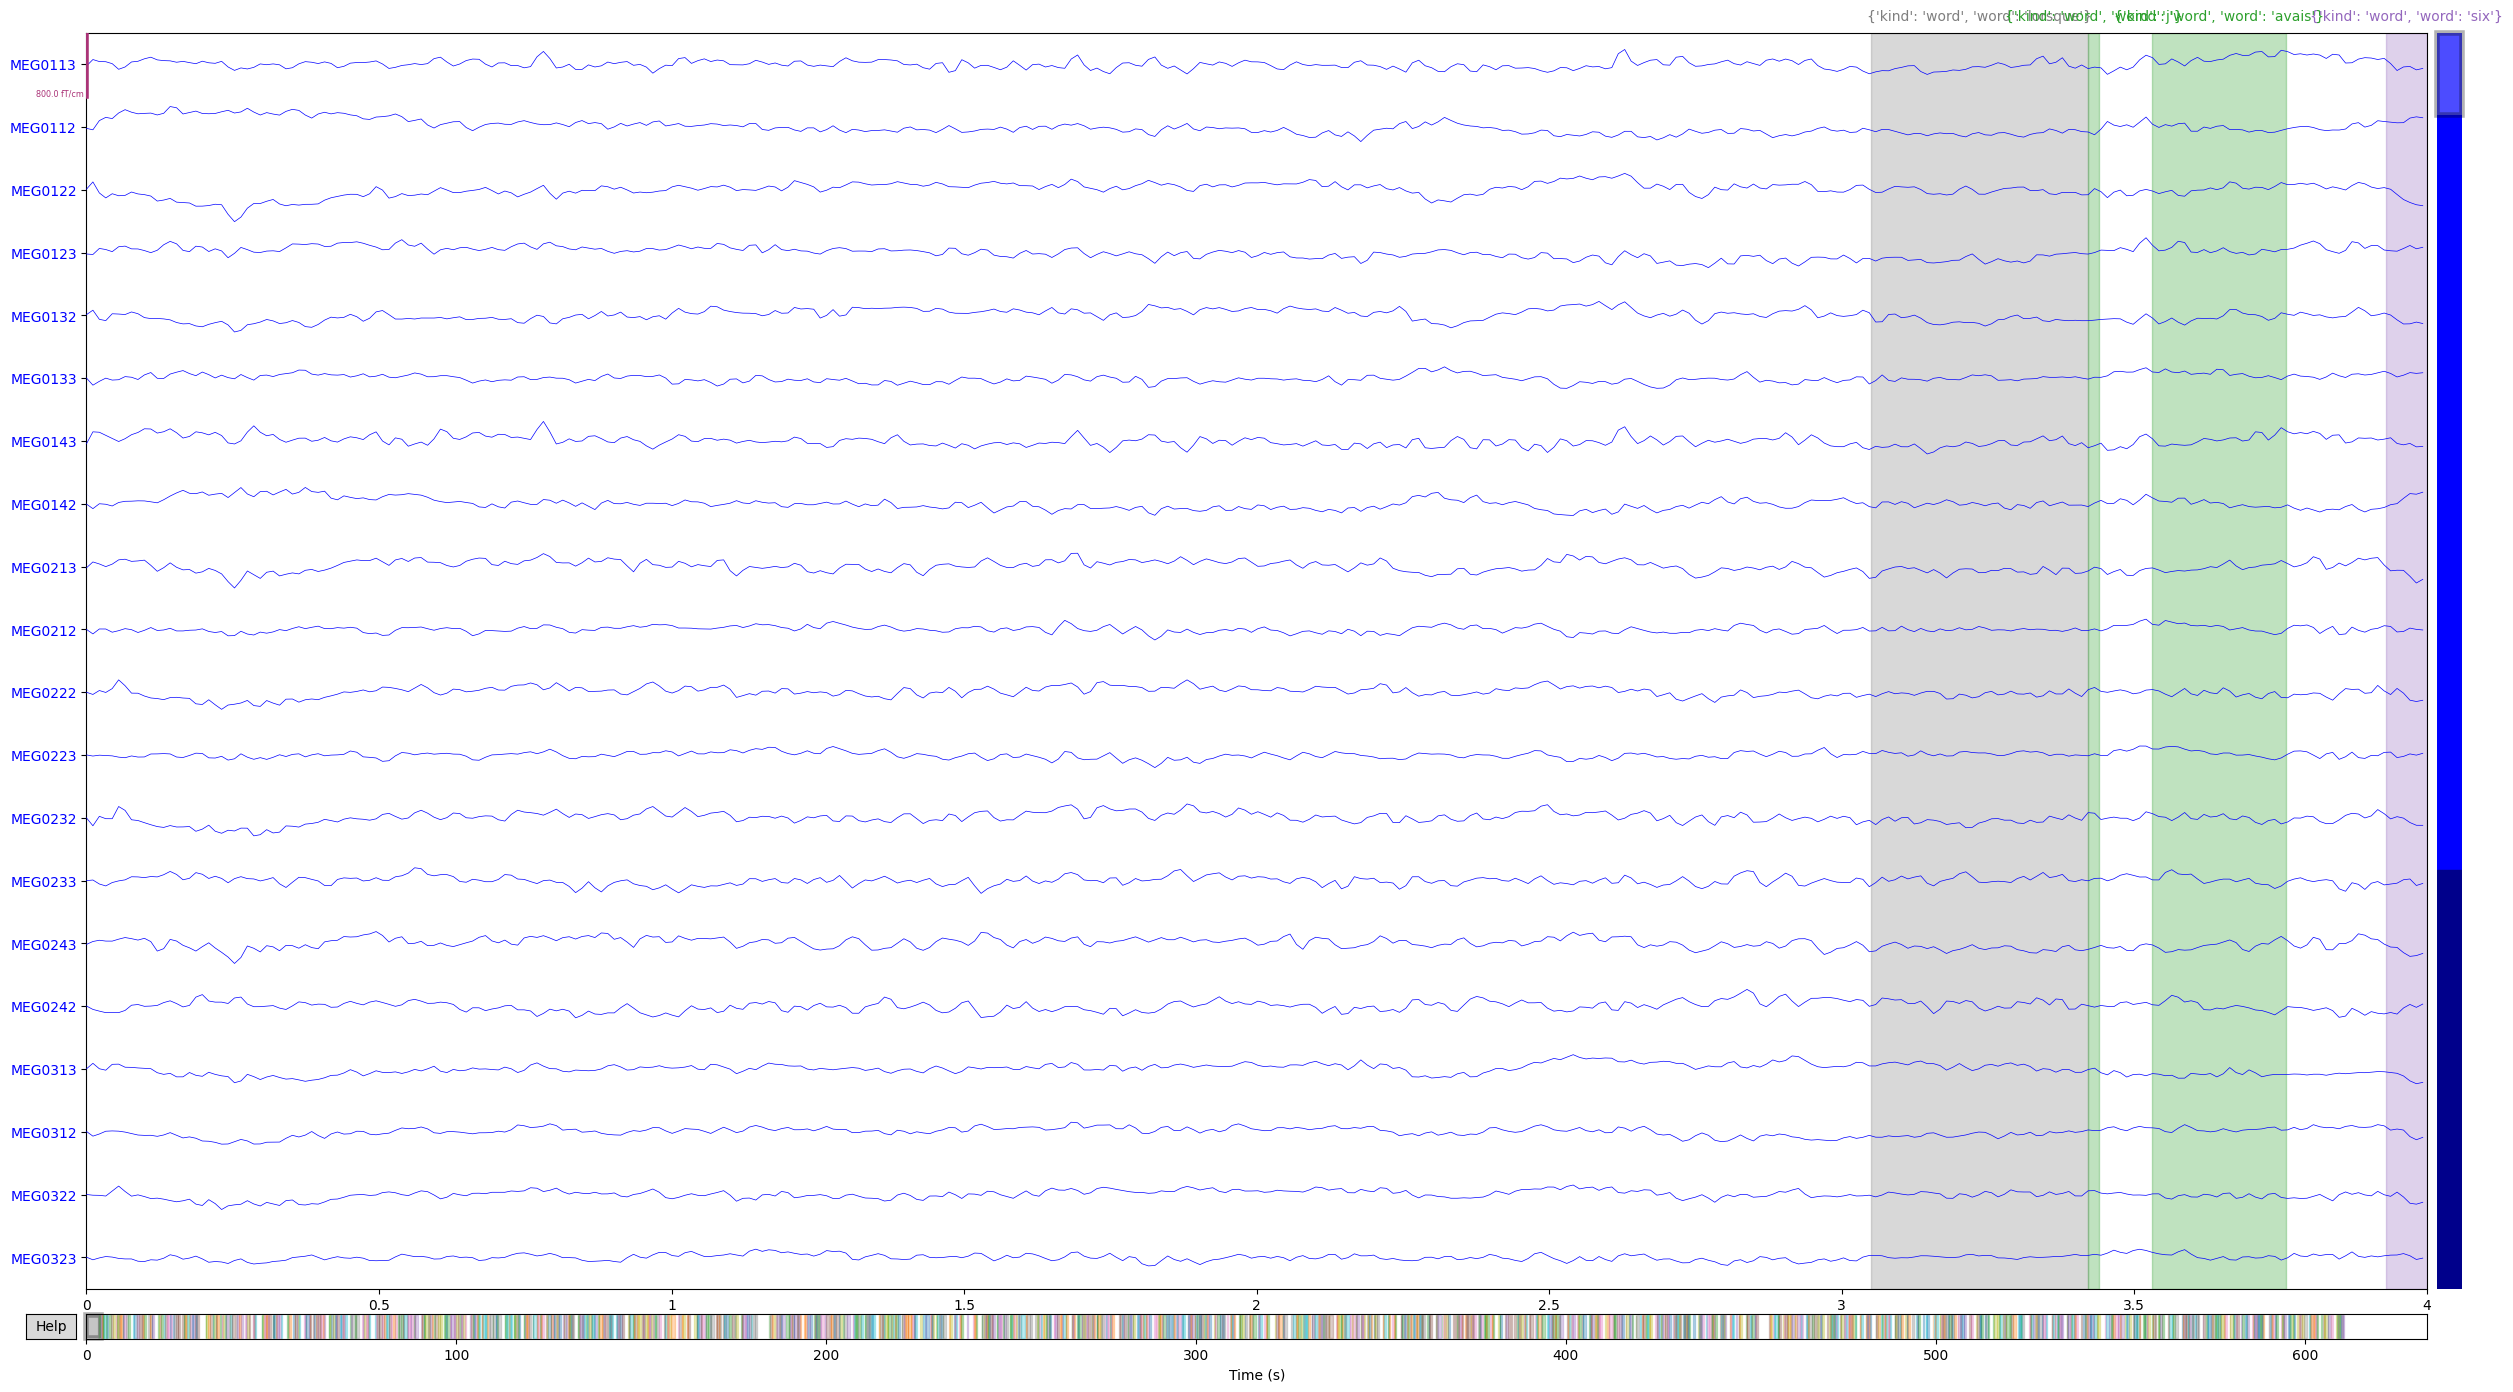

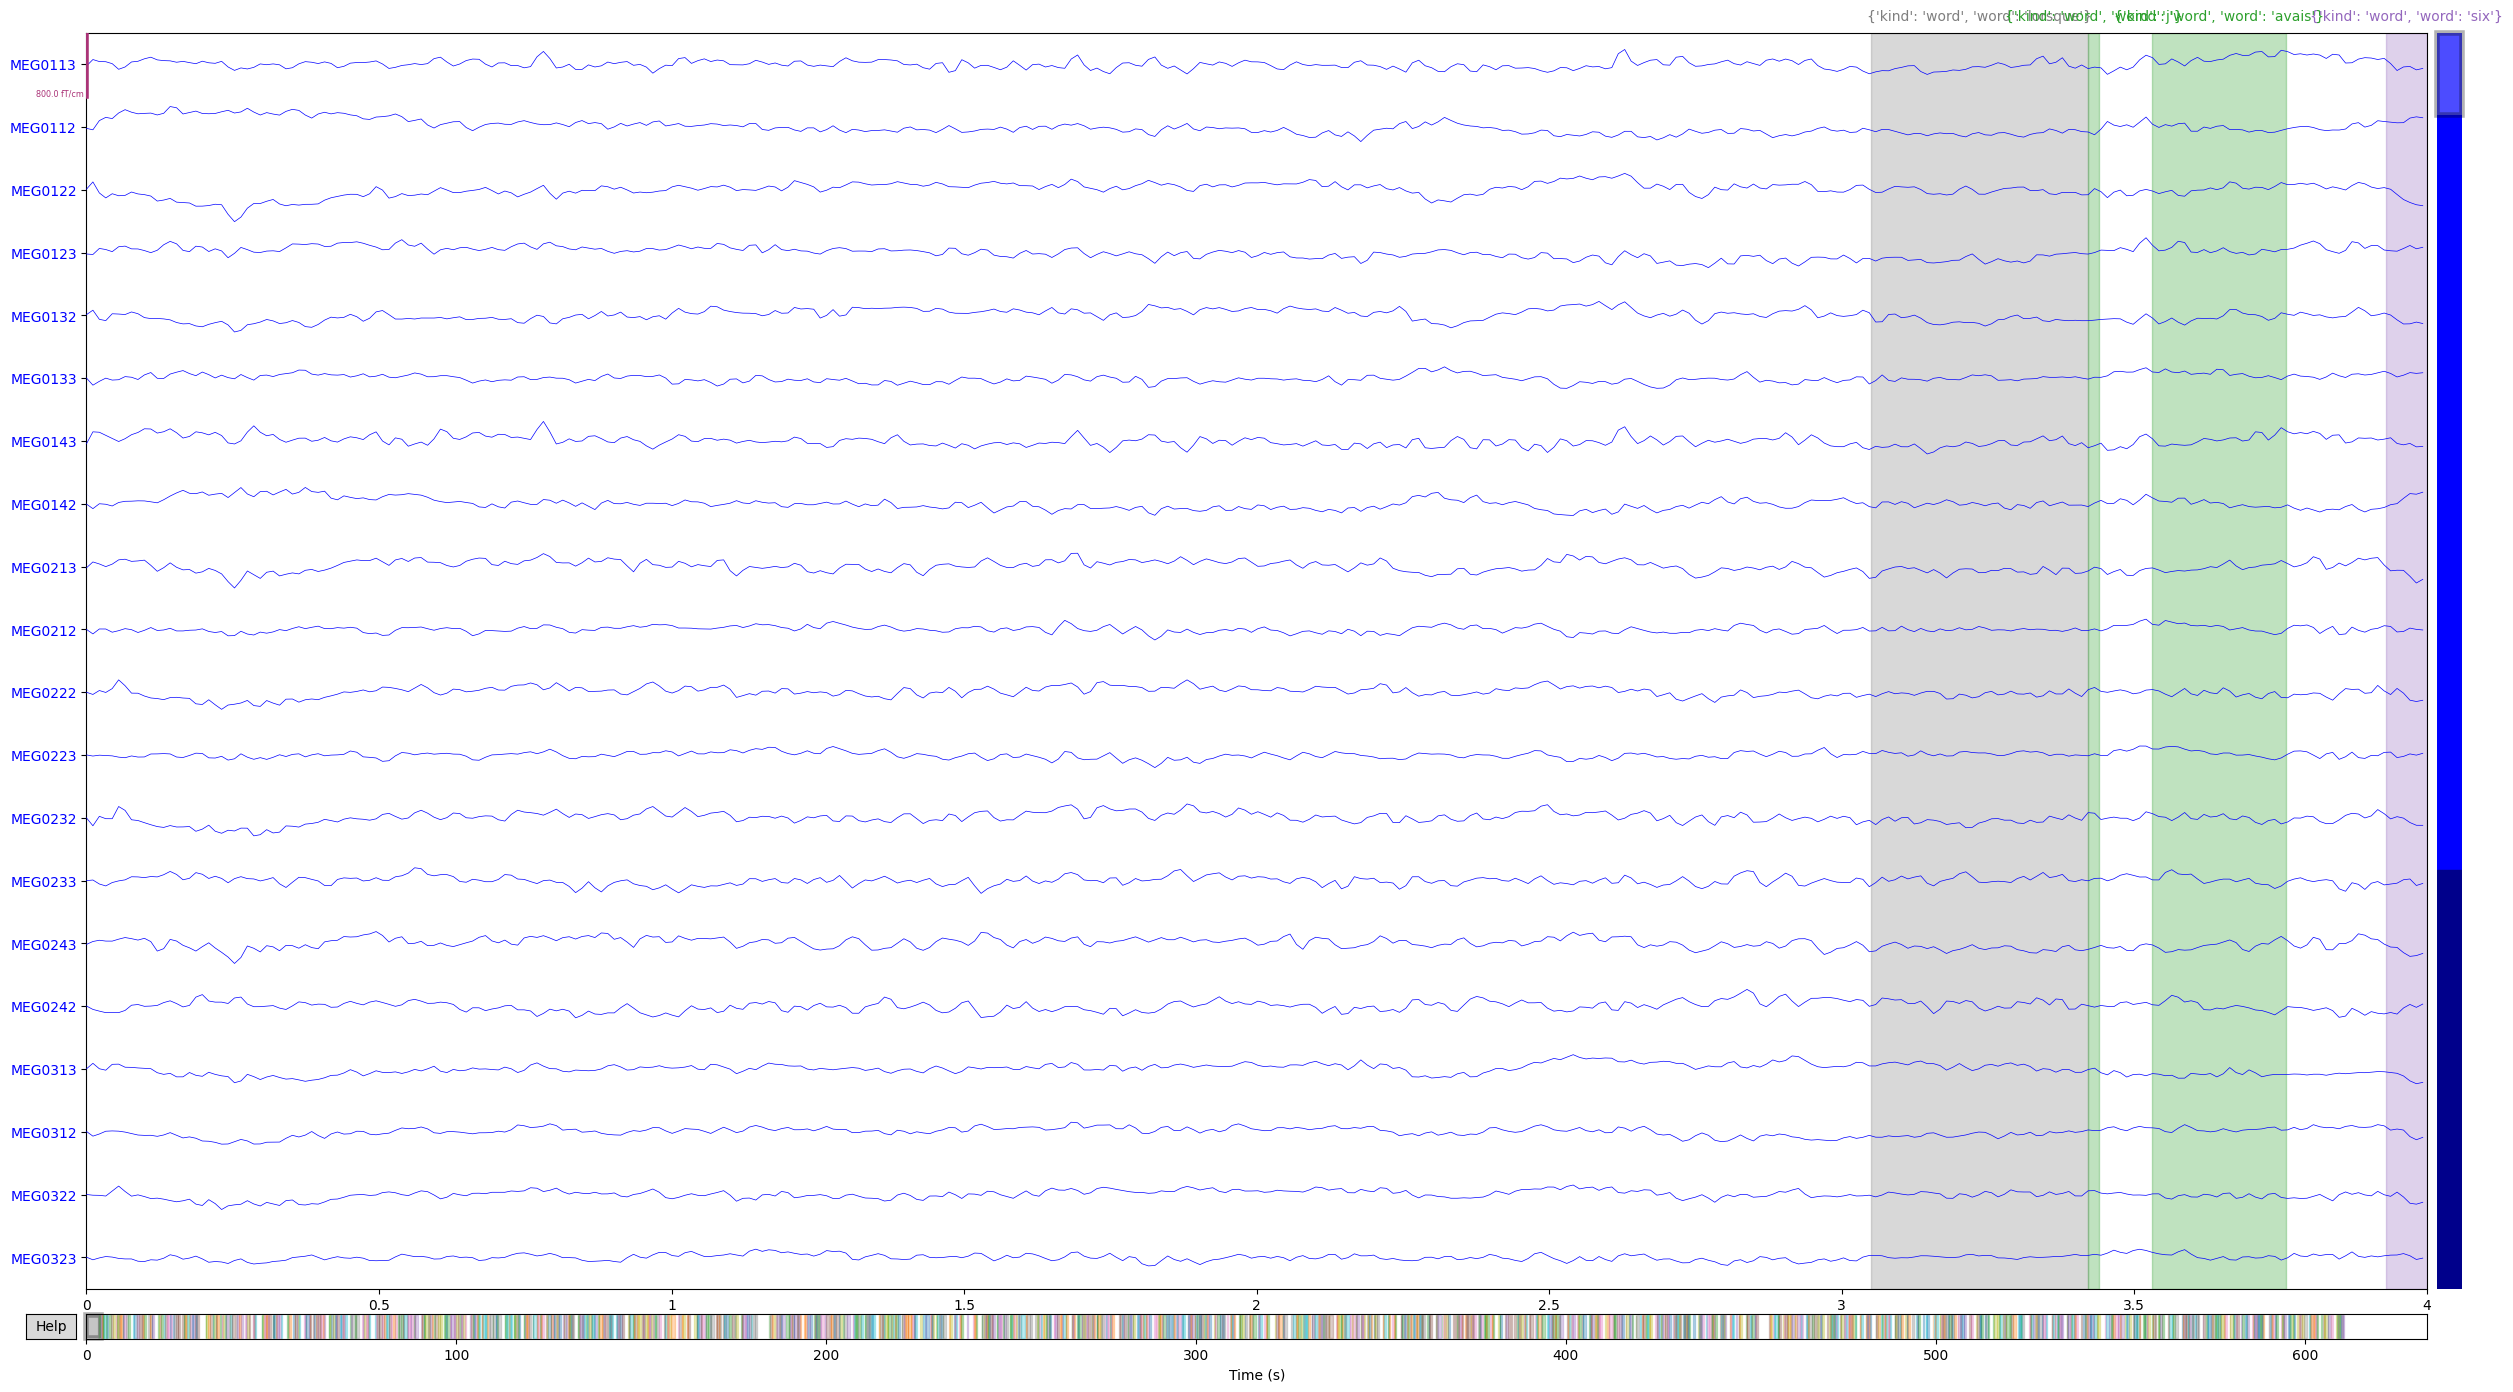

In [75]:
raw.plot(start = 0, duration = 4)

In [40]:
def _get_epochs(subject):
    all_epochs = list()
    for session in range(1,2):
        for run in range(1,2):
            task = 'rest'
            print(".", end="")
            bids_path = mne_bids.BIDSPath(
                subject=subject,
                session='0'+str(session),
                task=str(task),
                datatype="meg",
                root=bids,
                run = run,
                processing = "sss"
            )
            
            try:
                print(bids_path)
                raw = mne_bids.read_raw_bids(bids_path)
            except FileNotFoundError:
                print(f"missing, \nsubject:{subject}\nsession: {session}\ntask: {task}\nrun: {run}")
                continue
            raw = raw.pick_types(
                meg=True, misc=False, eeg=False, eog=False, ecg=False
            )

            raw.load_data().filter(0.5, 30.0, n_jobs=1)
            
            meta = list()
            # print(f"\n\n annot: {raw.annotations}\n\n")
            for annot in raw.annotations:
                try:
                    a = annot.pop("description")
                    d = eval(a)
                except:
                    print(f"eval error: {a}")
                    continue
                # print(f"\n\n d: {d}\n\n")
                for k, v in annot.items():
                    assert k not in d.keys()
                    d[k] = v
                meta.append(d)
            meta = pd.DataFrame(meta)
            meta["intercept"] = 1.0

            # segment on first event
            events = np.c_[
                meta.onset * raw.info["sfreq"], np.ones((len(meta), 2))
            ].astype(int)

            epochs = mne.Epochs(
                raw,
                events,
                tmin=-1.0,
                tmax=1.0,
                decim=10,
                baseline=(-1.0, 0.0),
                metadata=meta,
                preload=True,
                event_repeated="drop",
            )

            # threshold
            th = np.percentile(np.abs(epochs._data), 95)
            epochs._data[:] = np.clip(epochs._data, -th, th)
            epochs.apply_baseline()
            th = np.percentile(np.abs(epochs._data), 95)
            epochs._data[:] = np.clip(epochs._data, -th, th)
            epochs.apply_baseline()

            epochs.metadata["half"] = np.round(
                np.linspace(0, 1.0, len(epochs))
            ).astype(int)
            epochs.metadata["task"] = task
            epochs.metadata["session"] = session

            all_epochs.append(epochs)
    if not len(all_epochs):
        return
    epochs = mne.concatenate_epochs(all_epochs)
    m = epochs.metadata
    label = (
        "t"
        + m.task.astype(str)
        + "_s"
        + m.session.astype(str)
        + "_h"
        + m.half.astype(str)
    )
    epochs.metadata["label"] = label
    return epochs, raw, events


#### Explore subject 10 first

In [41]:
epochs ,raw, events = _get_epochs(subjects[10])

./home/is153802/workspace_LPP/data/MEG/LPP/derivatives/final_all/sub-220707/ses-01/meg/sub-220707_ses-01_task-rest_run-01_proc-sss_meg.fif


/tmp/ipykernel_352459/2694435461.py:19: RuntimeWarning: The number of channels in the channels.tsv sidecar file (346) does not match the number of channels in the raw data file (309). Will not try to set channel names.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/2694435461.py:19: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC201, MISC202, MISC203, MISC204, MISC205, MISC206, MISC301, MISC302, MISC303, MISC304, MISC305, MISC306, STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_352459/2694435461.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(all_epochs)


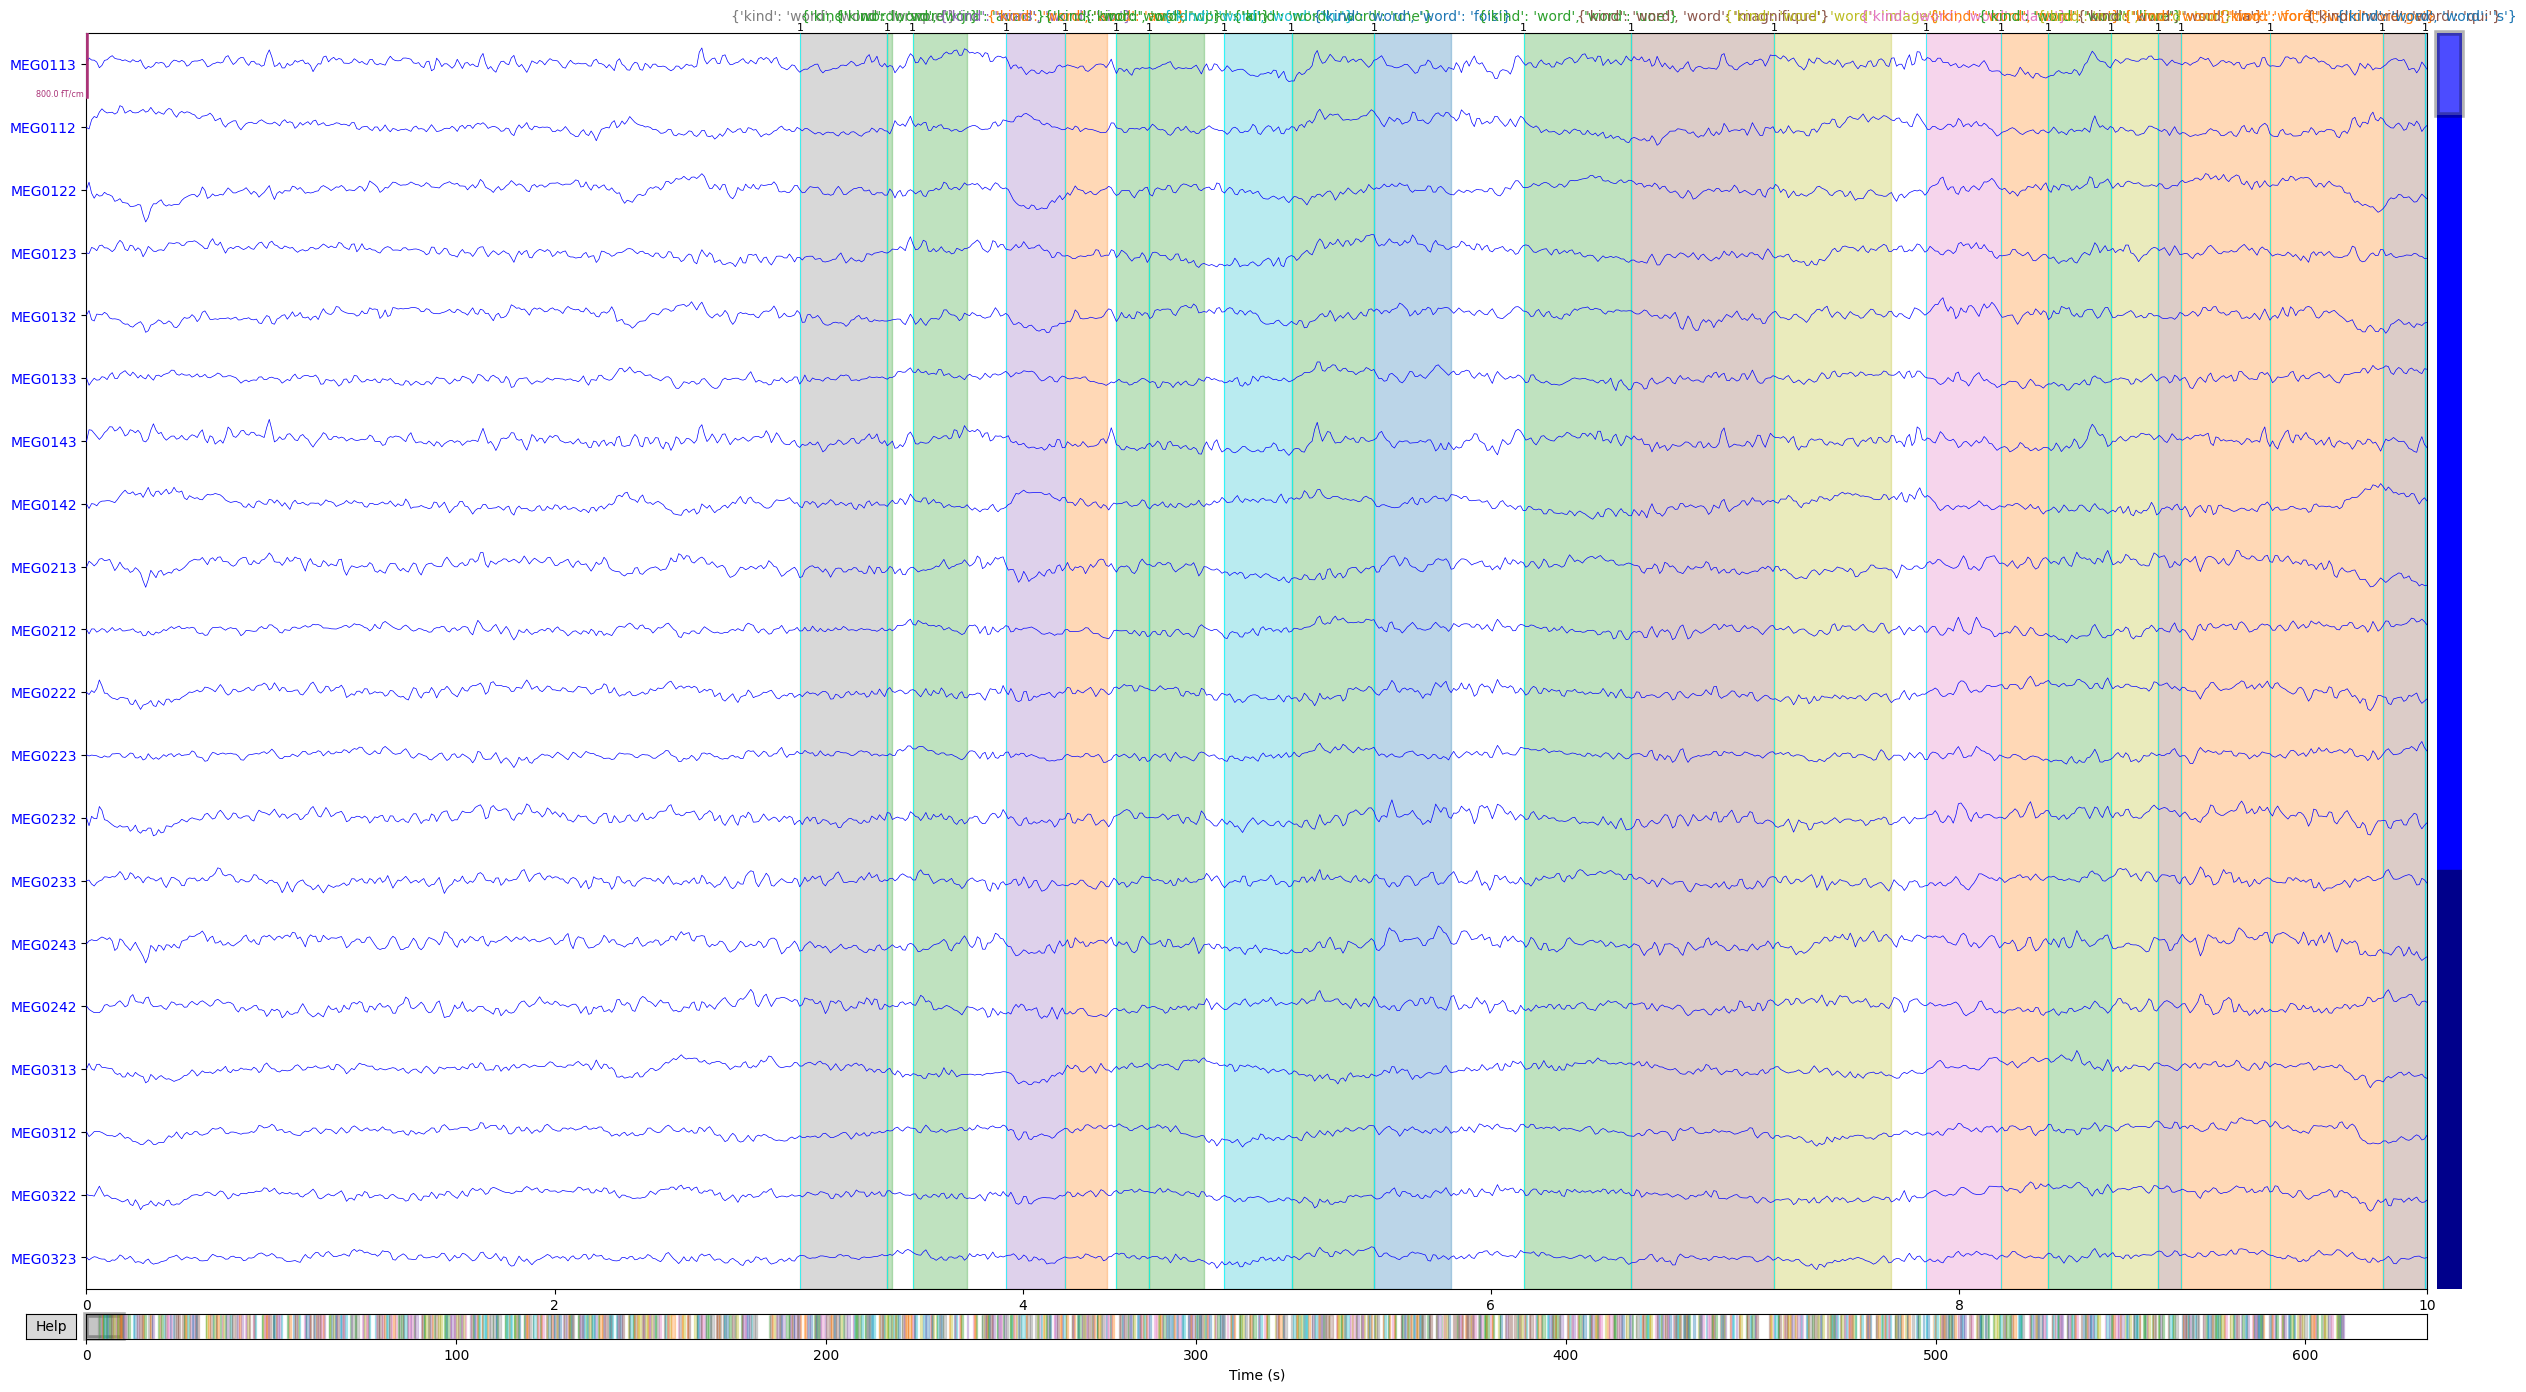

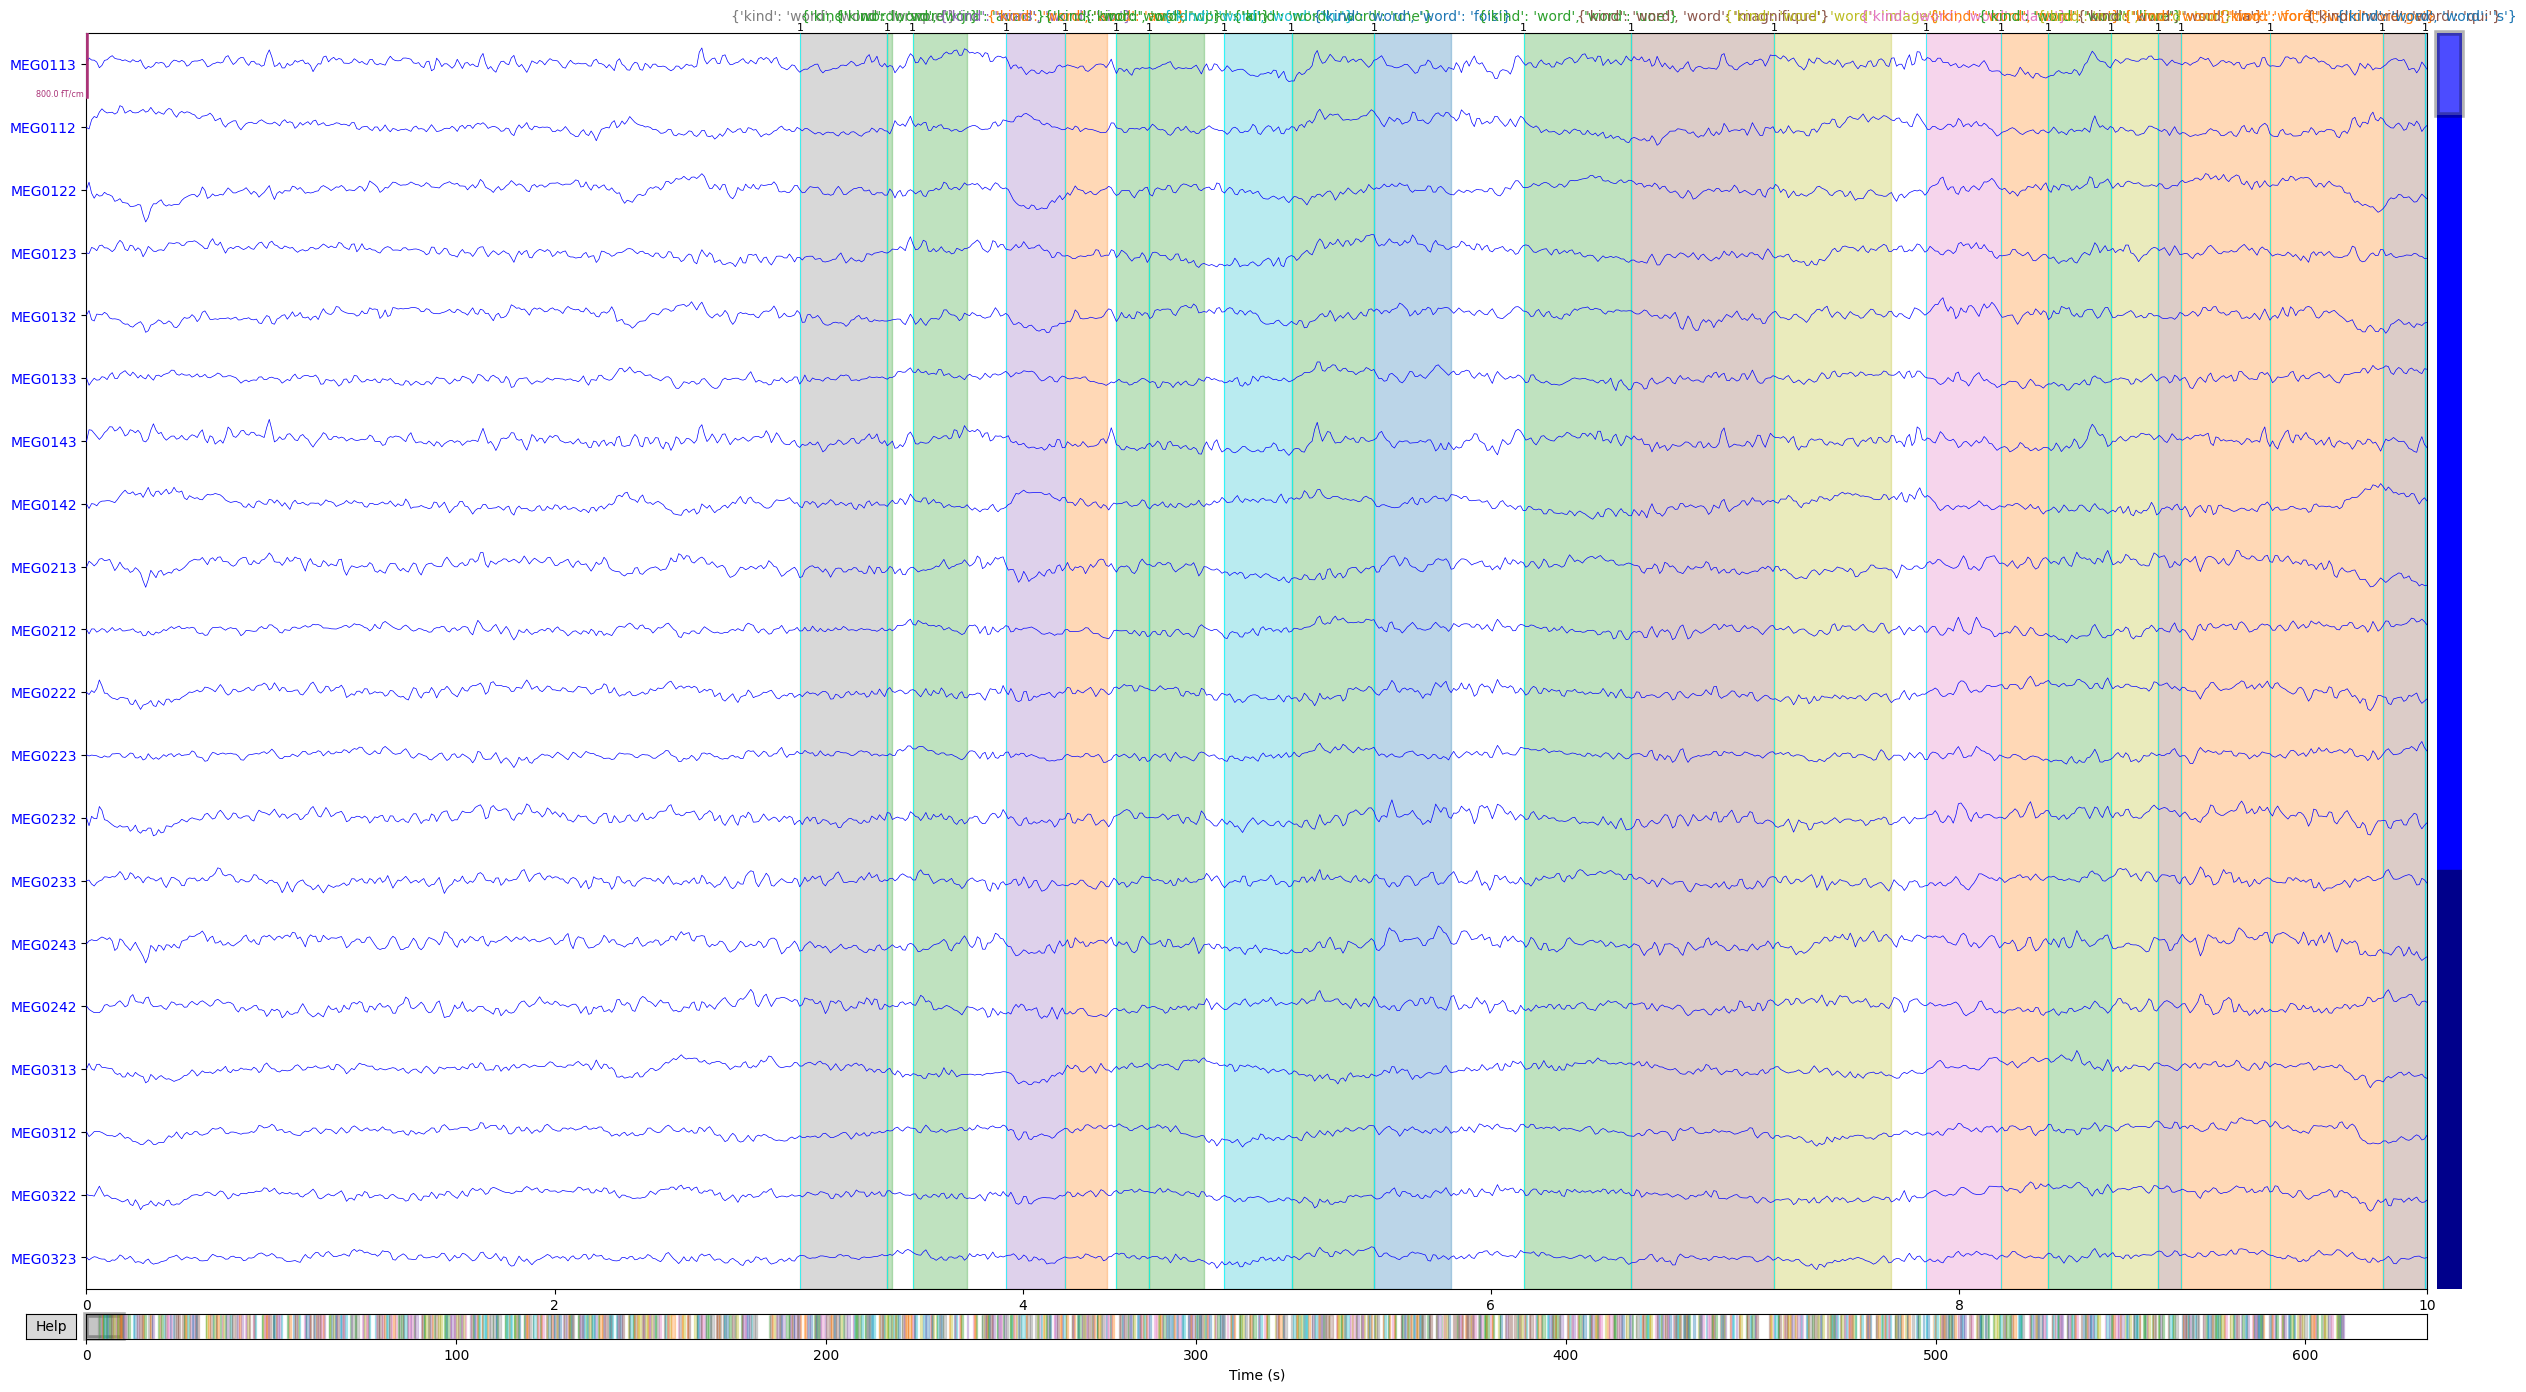

In [42]:
raw.plot(block=True,events=events)

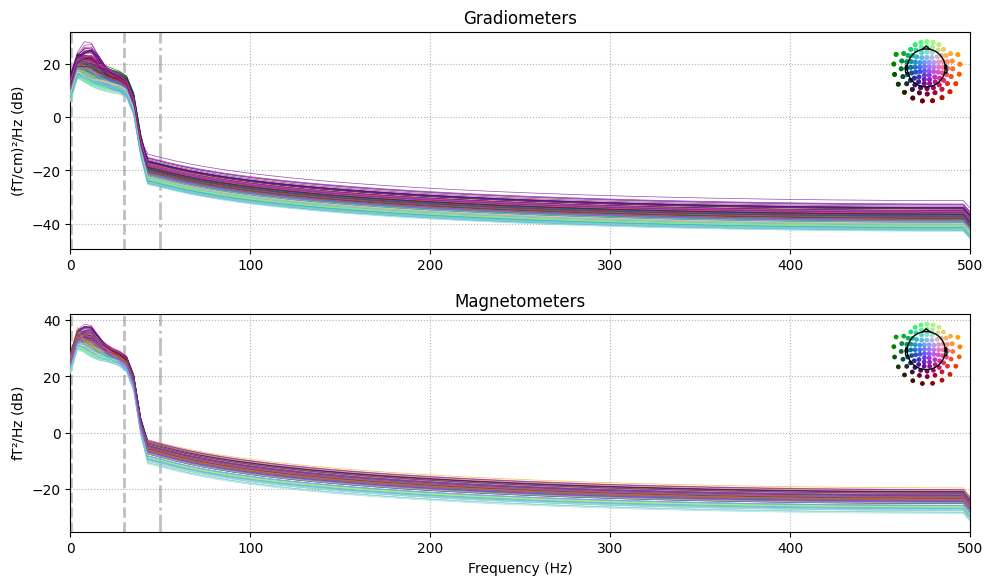

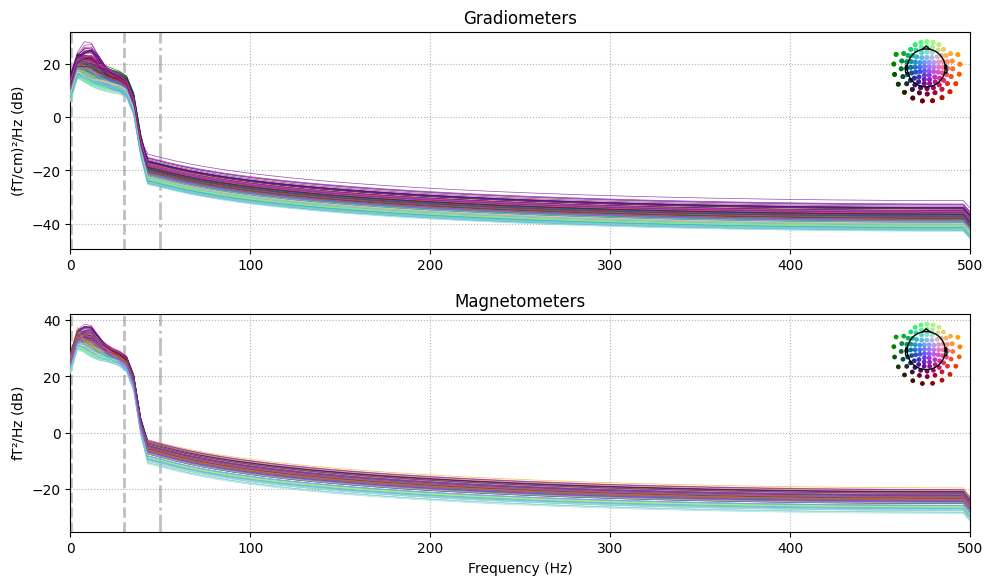

In [43]:
raw.plot_psd()

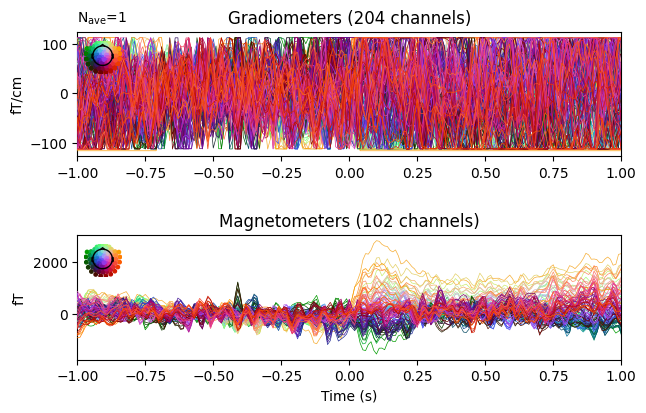

In [53]:
evo = epochs[3].average(method='median')
fig_evo = evo.plot(spatial_colors=True, show=False)


In [65]:
print(events[:,0]/raw.info['sfreq'])

[145.05 145.42 145.53 ... 751.87 752.04 752.2 ]


In [70]:
raw.annotations[0]

OrderedDict([('onset', 145.05),
             ('duration', 0.3700000000000001),
             ('description', "{'kind': 'word', 'word': 'lorsque'}"),
             ('orig_time',
              datetime.datetime(2022, 7, 7, 11, 58, 52, 907010, tzinfo=datetime.timezone.utc))])

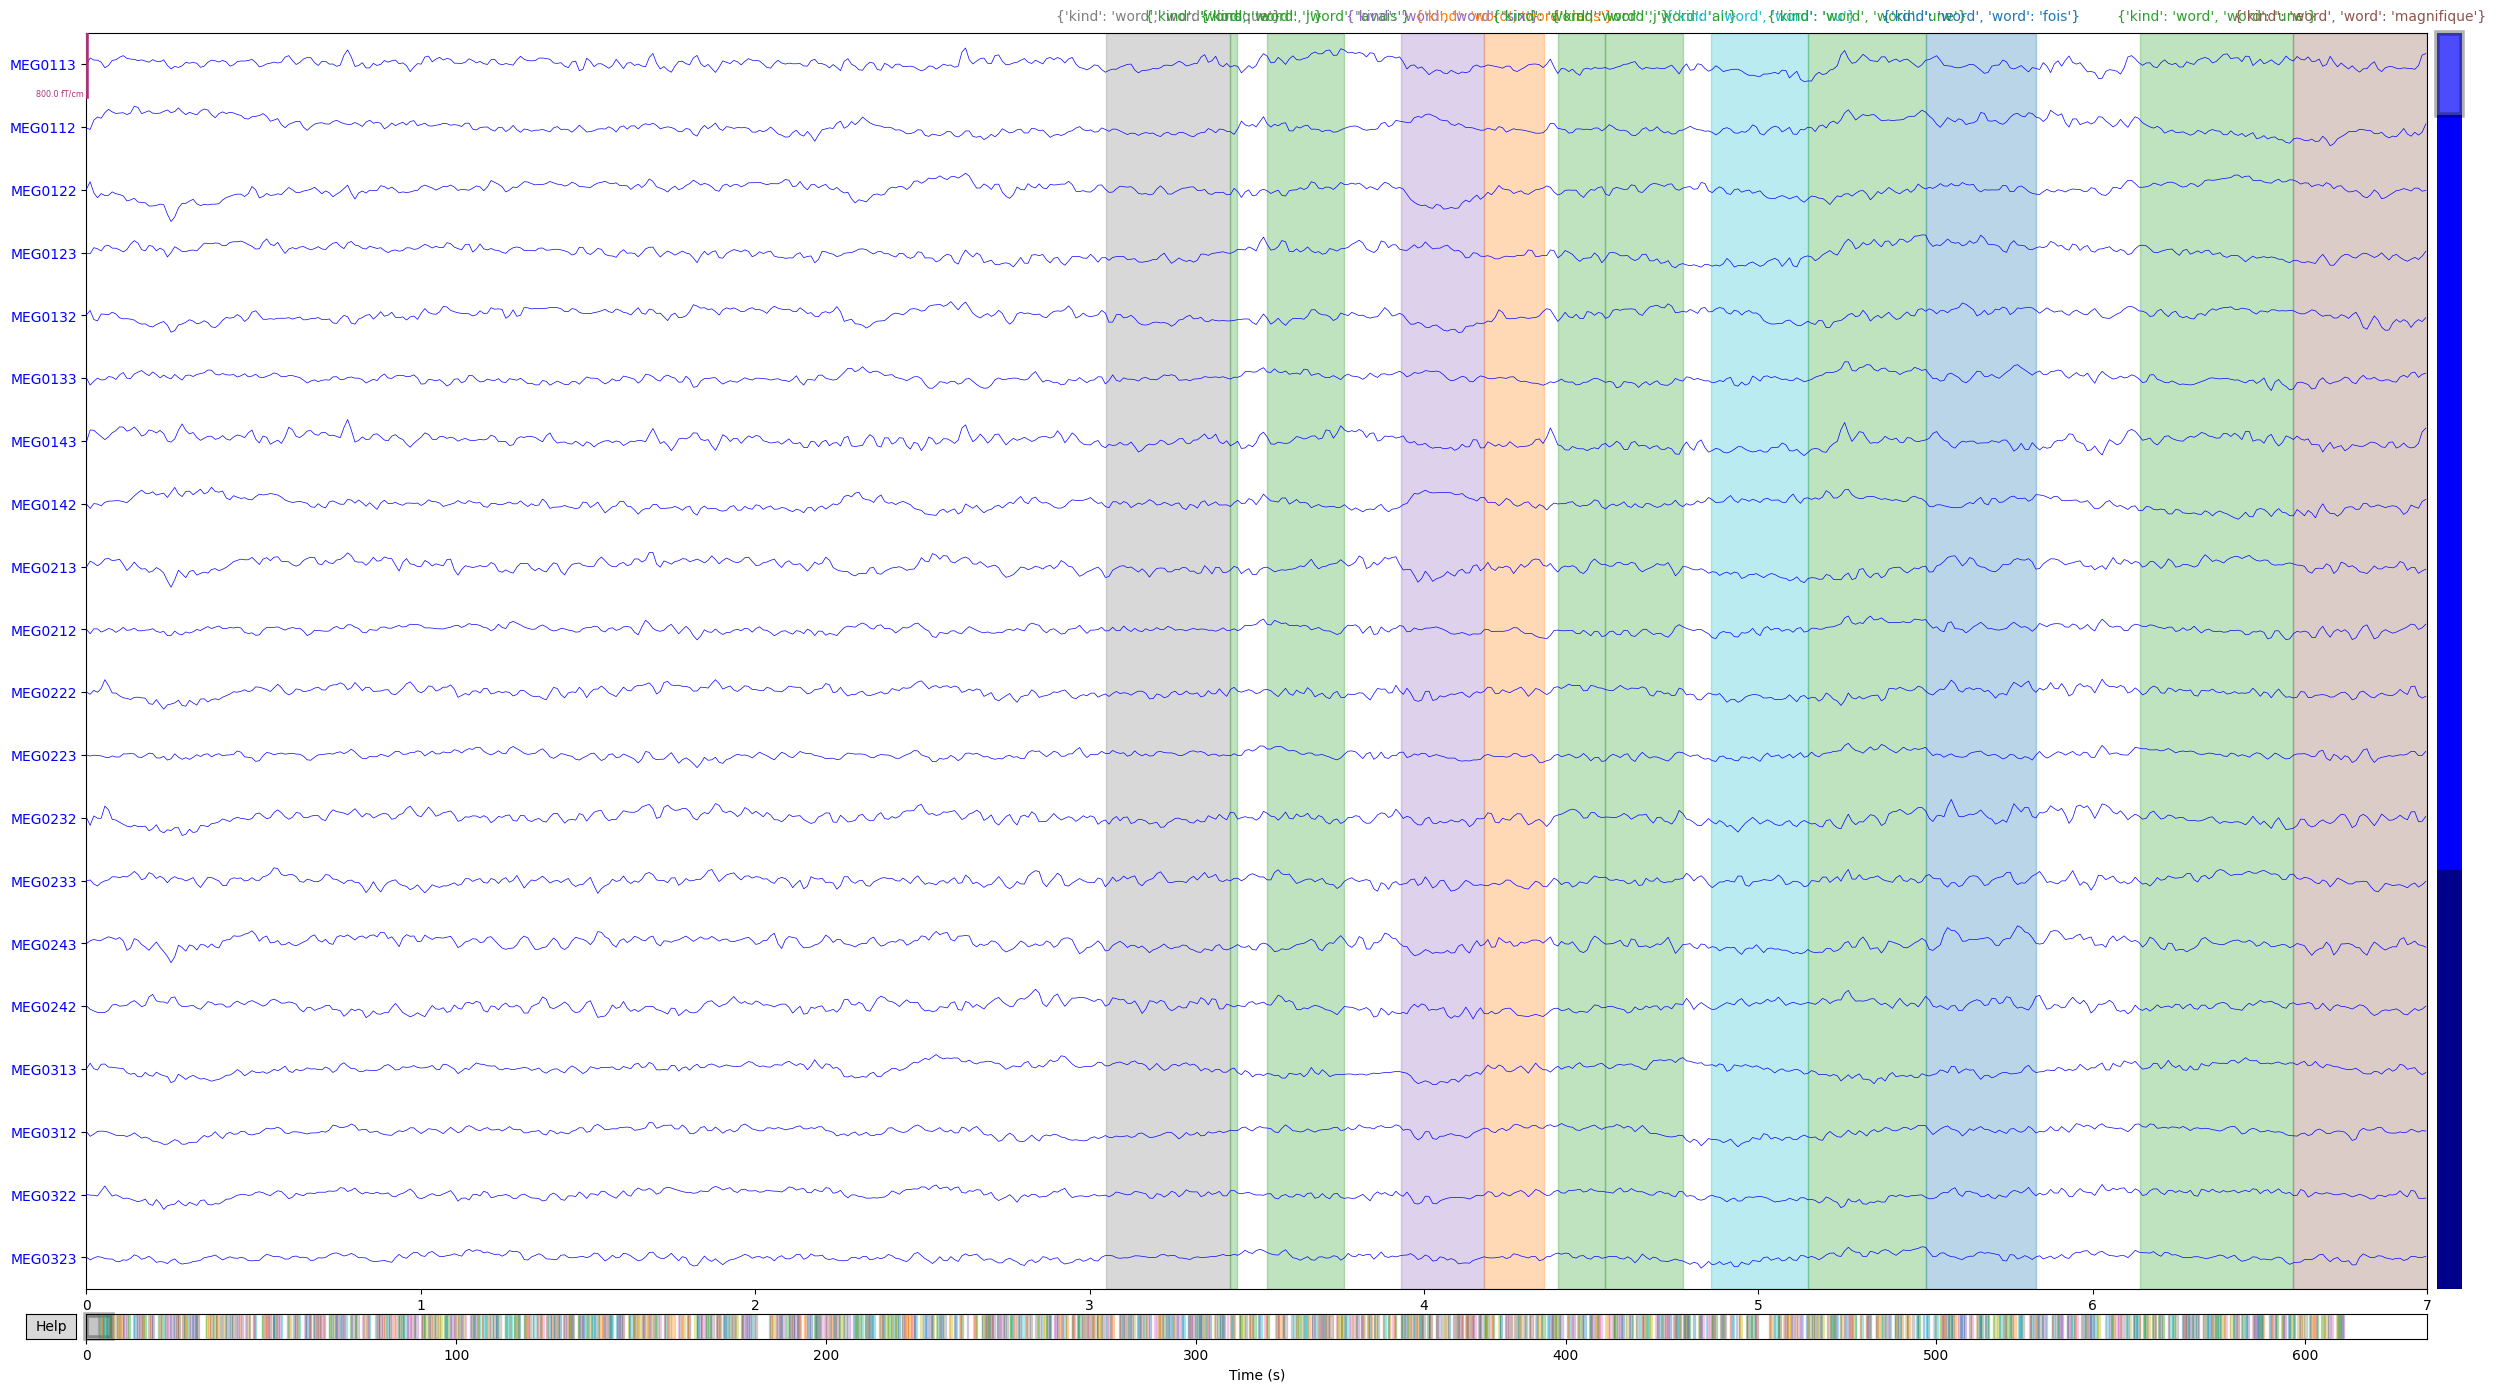

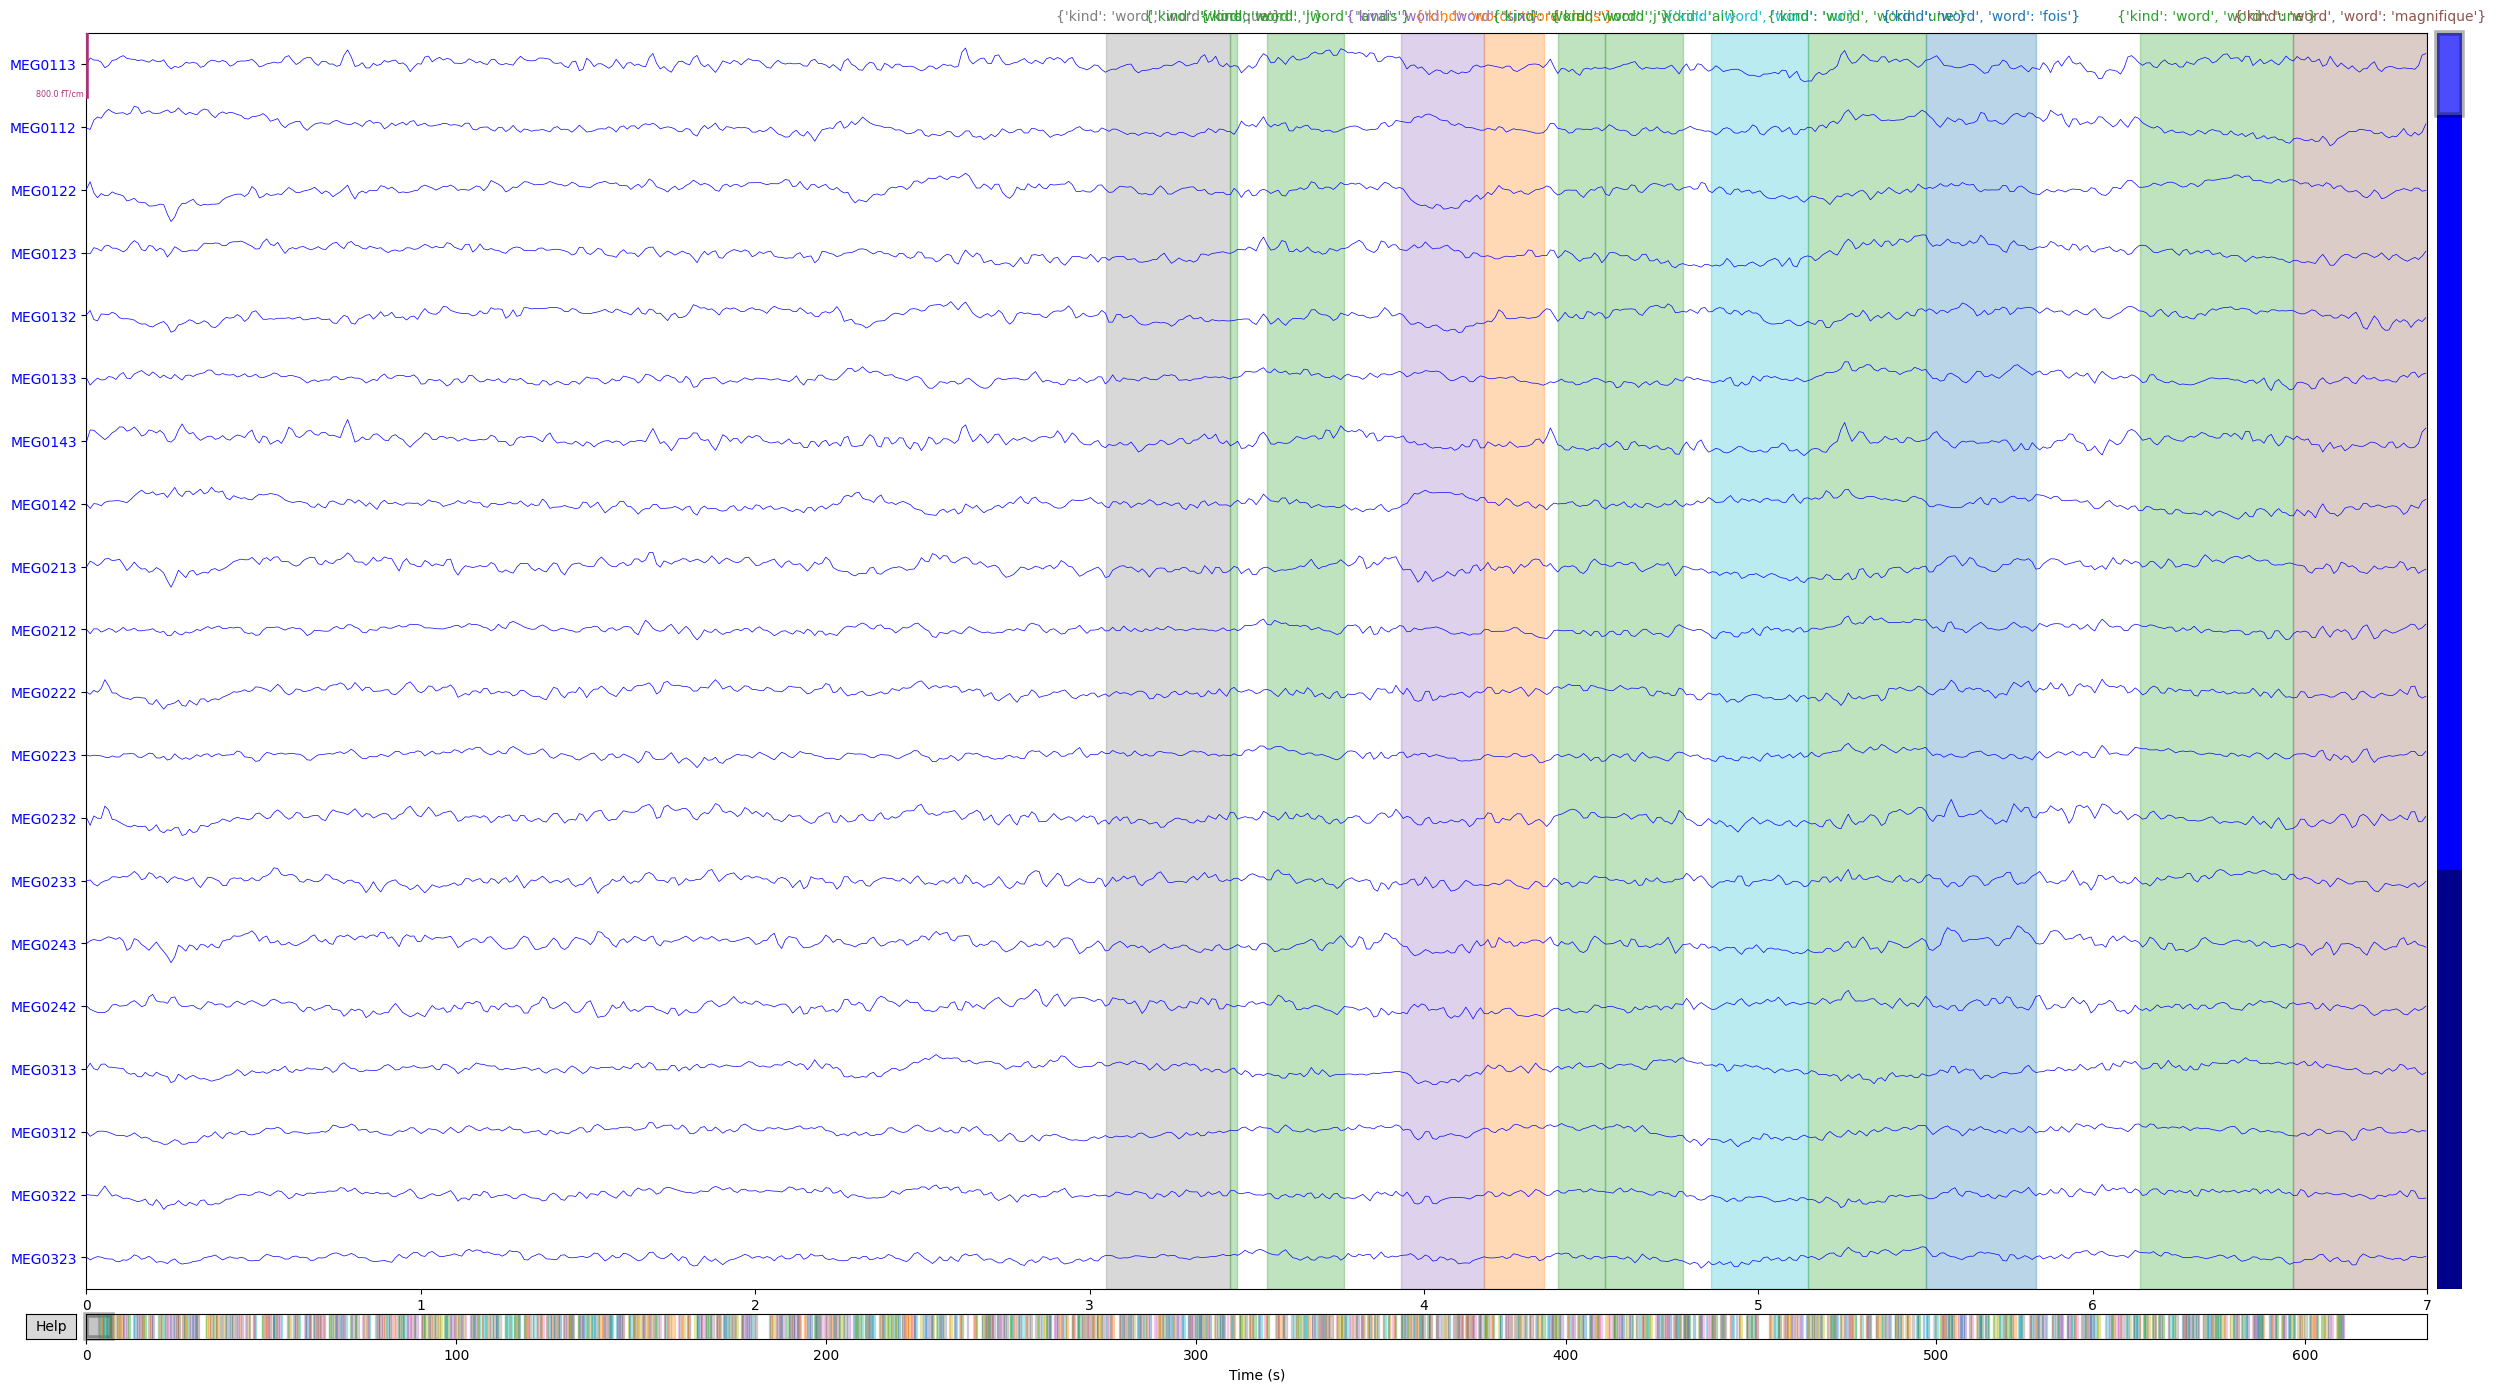

In [60]:

raw.plot(start=0, duration = 7)

# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2